In [3]:
import altair as alt
alt.renderers.enable('altair_saver', fmts=['png'])
from bayes_window import BayesWindow
from bayes_window.utils import load_radon
df = load_radon()

df

,county,radon,floor
0,0,2.2,1
1,0,2.2,0
2,0,2.9,0
3,0,1.0,0
4,1,3.1,0
...,...,...,...
922,83,6.4,0
923,83,4.5,0
924,83,5.0,0
925,84,3.7,0


In [4]:
window=BayesWindow(df.reset_index(), y='radon', treatment='floor',group='county')

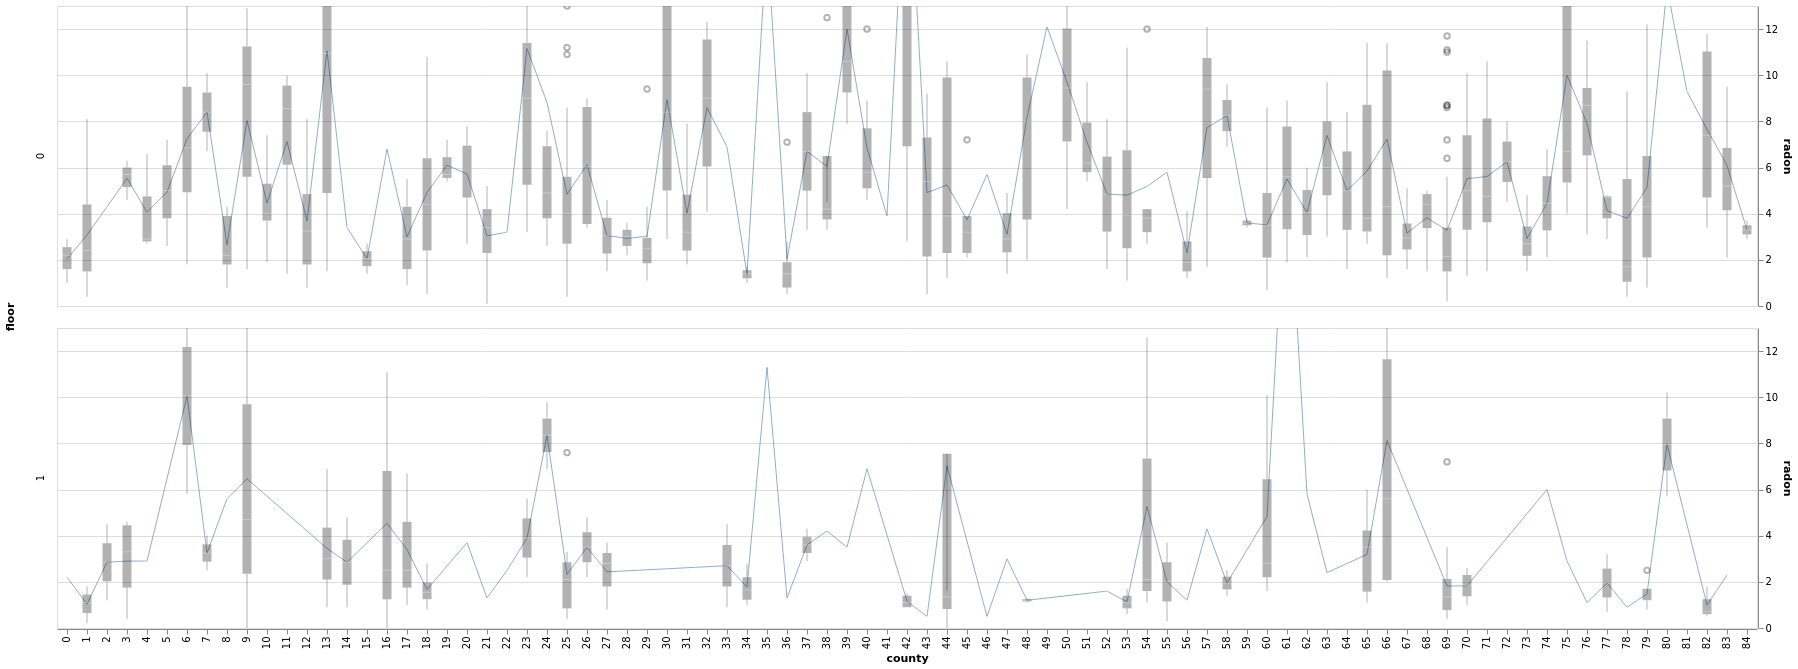

In [5]:
window.plot(x='county').facet(row='floor')

Using formula radon ~  floor + (1 | county)
             Coef. Std.Err.       z  P>|z|  [0.025  0.975]
Intercept    5.493    0.525  10.464  0.000   4.464   6.522
floor       -2.289    0.388  -5.899  0.000  -3.050  -1.529
1 | county   0.005    0.011   0.450  0.653  -0.016   0.025
Group Var    2.852    0.207                               


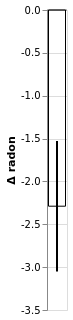

In [6]:
window.fit_lme()#override_formula='radon ~ floor + ( 1 | county)')

window.plot(add_data=False)

In [7]:
window1=BayesWindow(df.reset_index(), y='radon', treatment='floor',group='county')
window1.fit_slopes(add_group_intercept=True);



Uneven number of entries in conditions! This will lead to nans in data (window.data["radon diff"(170, 120)


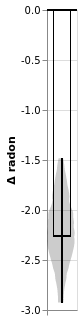

In [8]:
window1.plot(x=':O',add_data=False,add_posterior_density=True)

TODO plot_intercept_with_details() 

Uneven number of entries in conditions! This will lead to nans in data (window.data["radon diff"(170, 120)


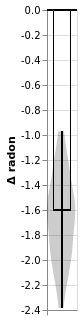

In [9]:
window2=BayesWindow(df.reset_index(), y='radon', treatment='floor',group='county')
window2.fit_slopes(add_group_intercept=False, add_group_slope=False, do_make_change='subtract');

window2.plot(x=':O',add_data=False,add_posterior_density=True)

In [10]:
import arviz as az
datasets = {'unpooled' : window2.trace.posterior,
           'hierarchical': window1.trace.posterior} 

az.plot_forest(data=list(datasets.values()), model_names=list(datasets.keys()), 
               backend='bokeh',
               #kind='ridgeplot',
               #ridgeplot_overlap=1.6,
               combined=True);

